In [22]:
import os
import networkx as nx
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf, ccf
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sys
from datetime import datetime
import numpy as np
from Swing import Swing
from Swing.util.Evaluator import Evaluator
import numpy as np


In [23]:
def get_experiment_list(filename):
    # load files
    timecourse = pd.read_csv(filename, sep="\t")
    # divide into list of dataframes
    experiments = []
    for i in range(0,85,21):
        experiments.append(timecourse.ix[i:i+20])
    #reformat
    for idx,exp in enumerate(experiments):
        exp = exp.set_index('Time')
        experiments[idx]=exp
    return(experiments)

def identify_lags(experiments, true_edges, swing_obj, perturb_idx=0, auto_len=10, p_thresh=0.05):
    for ee, experiment in enumerate(experiments):
        for parent, child in true_edges:
            data_df = pd.DataFrame()
            data_df['Parent'] = experiment[parent]
            data_df['Child'] = experiment[child]
            auto_parent = acf(data_df['Parent'])
            auto_child = acf(data_df['Child'])
            pval_parent = stats.linregress(data_df.index[:auto_len], auto_parent[:auto_len]).pvalue*len(swing_obj.gene_list)
            pval_child = stats.linregress(data_df.index[:auto_len], auto_child[:auto_len]).pvalue*len(swing_obj.gene_list)
            if pval_parent < p_thresh and pval_child < p_thresh:
                perturb_df = data_df.iloc[perturb_idx:]
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
                ax1.plot(perturb_df.index,  perturb_df['Parent'], 'o-', label=parent)
                ax1.plot(perturb_df.index,  perturb_df['Child'], 'o-', label=child)
                ax1.set_title(ee)
                ax1.legend(loc='best')
                ccf_forward = ccf(perturb_df['Parent'],  perturb_df['Child'])
                ccf_reverse = ccf( perturb_df['Child'], perturb_df['Parent'])
                diff = (ccf_forward-ccf_reverse)/range(1,len(perturb_df.index)+1)
                diff = diff/np.max(np.abs(diff))
                ax2.plot(perturb_df.index, ccf_forward, 'o-', c='c', label='forward')
                ax2.plot(perturb_df.index, ccf_reverse, 'o-', c='m', label='reverse')
                ax2.plot(perturb_df.index, diff, 'o-', c='k', label='diff')
                ax2.set_ylim([-1, 1])
                ax2.legend(loc='best')

### How does ACF compare when all tracks for a gene are combined?

In [24]:
file_path = "../data/dream4/insilico_size10_1_timeseries.tsv"
df = pd.read_csv(file_path, sep="\t")
gene_list = df.columns.values[1:].tolist()
experiments=get_experiment_list(file_path)

In [25]:
def ac_tracks(experiments, auto_len=10):
    """Autocorrelate gene tracks for each experiment
    """     
    ac = np.array([[acf(experiment[track]) for track in experiment]for experiment in experiments])
    return ac

def ac_genes(dataframe):
    ac = np.array([acf(dataframe[gene], nlags=len(dataframe)) for gene in dataframe if gene!='Time'])
    return ac

In [26]:
a = ac_genes(df)
auto = np.reshape(ac_tracks(experiments), a.shape)

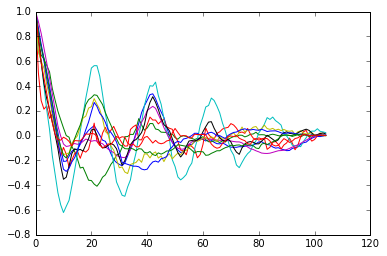

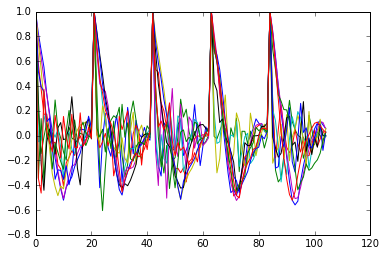

In [27]:
# It doesn't appear the same
plt.plot(a.T)
plt.figure()
plt.plot(auto.T)

In [28]:
def xcorr_experiments(experiments, gene_axis=1):
    #### NOTE #####
    #### SCIPY may have a way to do this efficiently for 2d arrays. Take a look when possible ##############
    return np.array([cc_experiment(experiment.values.T) if gene_axis==1 else cc_experiment(experiment.values)
            for experiment in experiments])

def cc_experiment(x):
    """
    For one experiment. 
    x should be n rows (genes) by m columns (timepoints)
    """
    ccf_array = np.zeros((x.shape[0], x.shape[0], x.shape[1]))
    for ii, static in enumerate(x):
        for jj, moving in enumerate(x):
            if ii==jj:
                unbiased=True
            else:
                unbiased=False
            ccf_array[ii][jj] = ccf(static, moving, unbiased=unbiased)
    return ccf_array



xcorr_list = xcorr_experiments(experiments)

In [29]:
def calc_stationarity(xcorr_list, corr_len=10, x_axis=None):
    if x_axis is None:
        x_axis=np.array(range(corr_len))
    x_axis = x_axis[:corr_len]
    slope_list = []
    pval_list = []
    for xcorr_array in xcorr_list:        
        slopes=[]
        pvals=[]
        ac_tracks = np.diagonal(xcorr_array).T
        for track in ac_tracks:
            line = stats.linregress(x_axis, track[:corr_len])
            slopes.append(line.slope)
            pvals.append(line.pvalue)
        slope_list.append(slopes)
        pval_list.append(pvals)
    pval_array = np.array(pval_list).T*len(ac_tracks)
    return np.array(slope_list).T, pval_array

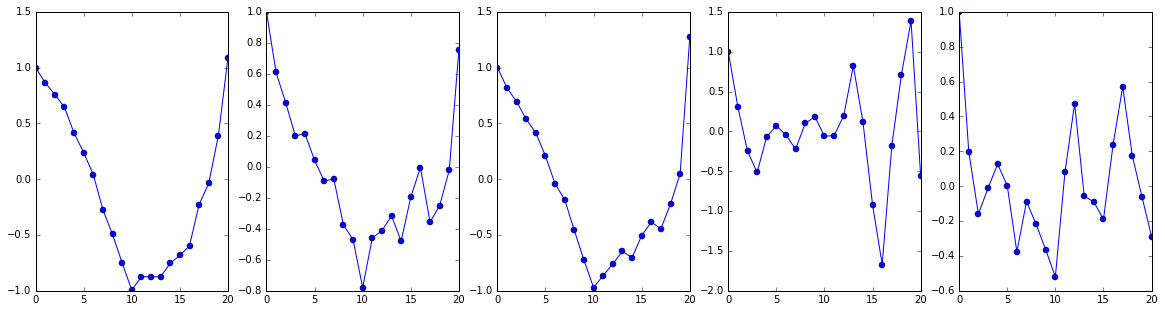

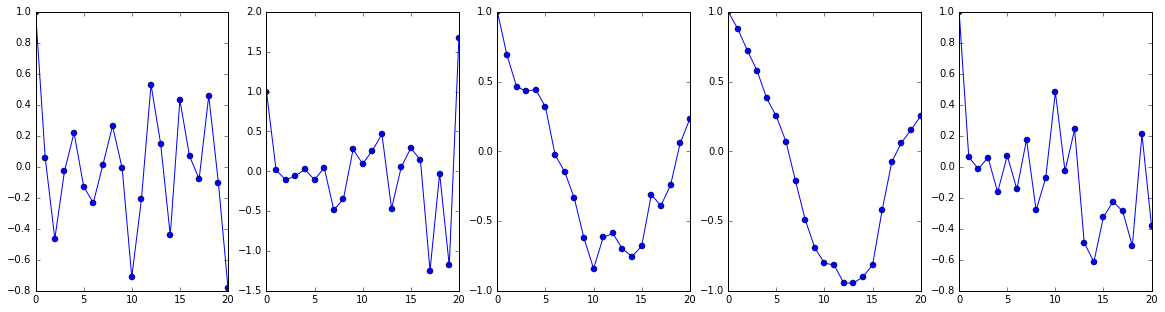

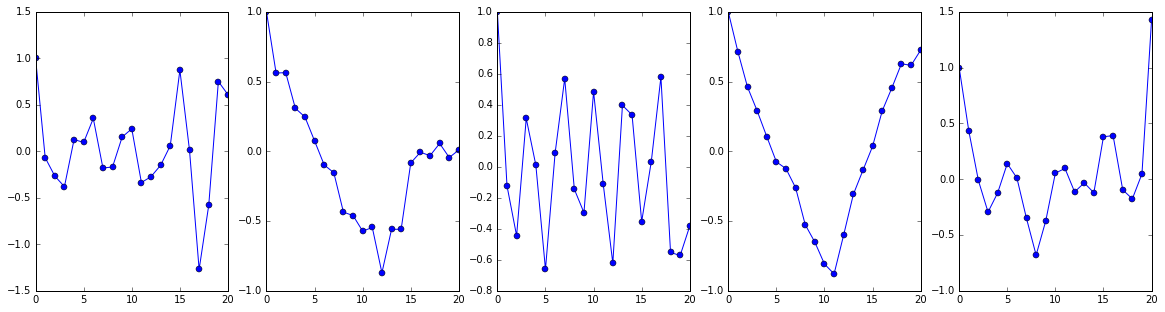

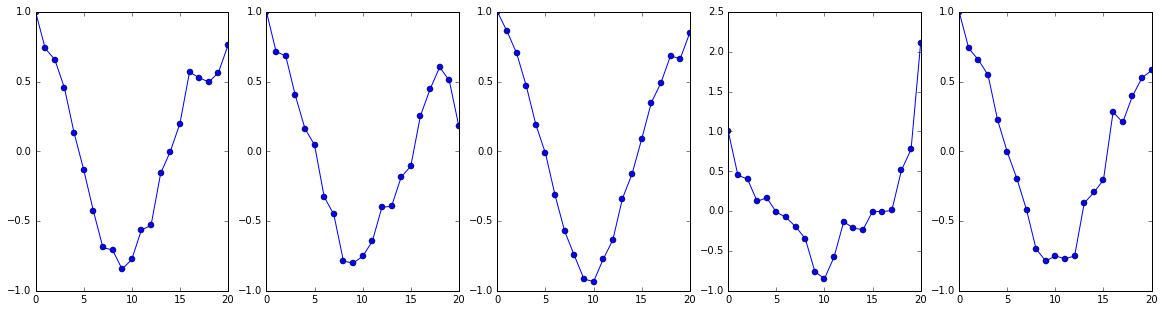

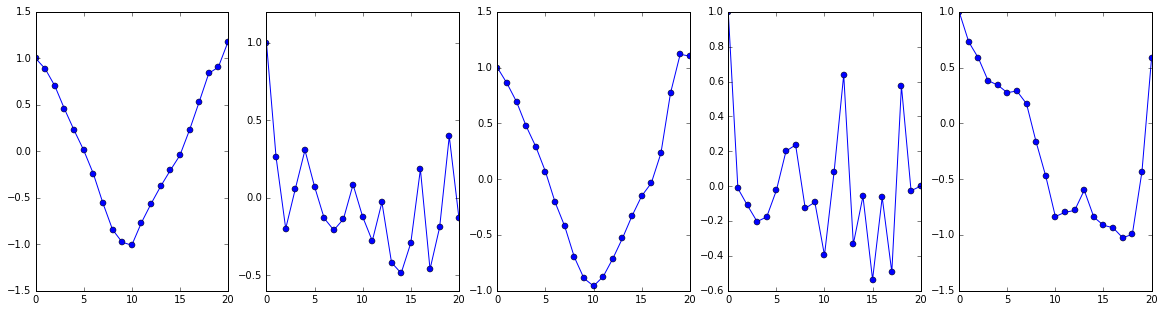

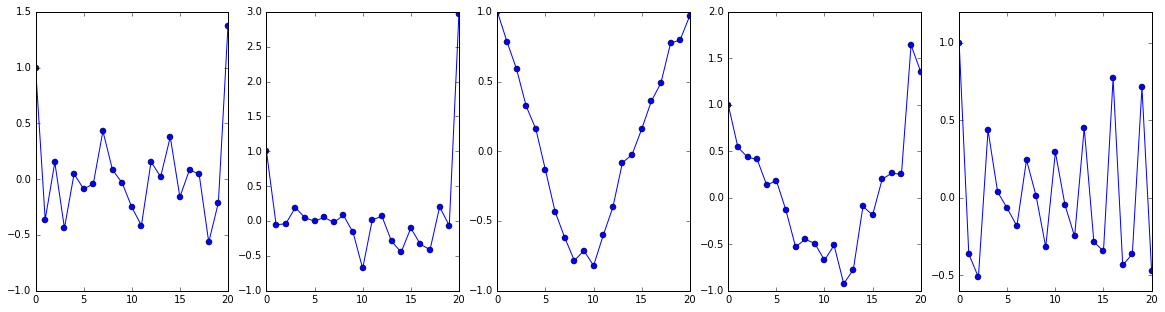

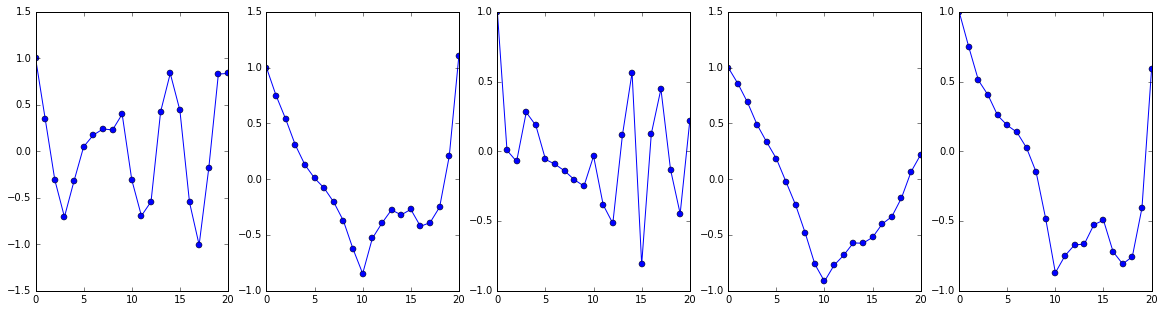

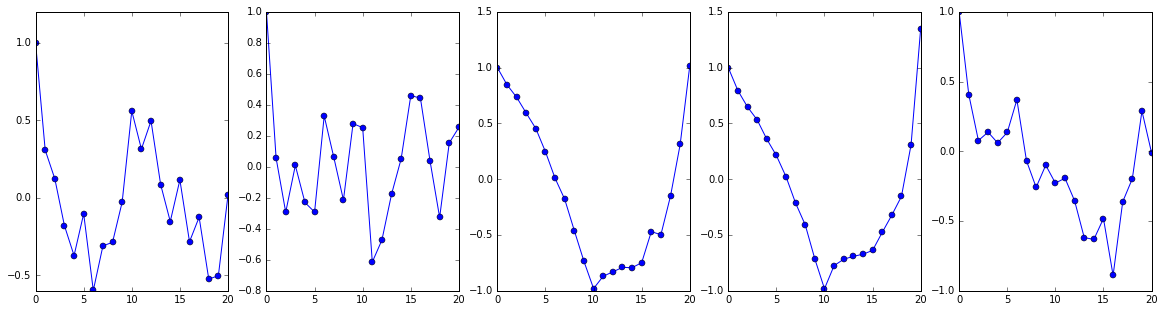

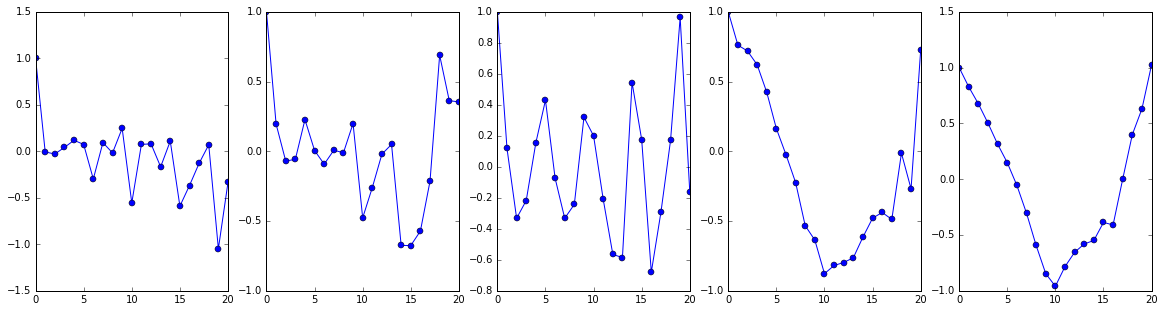

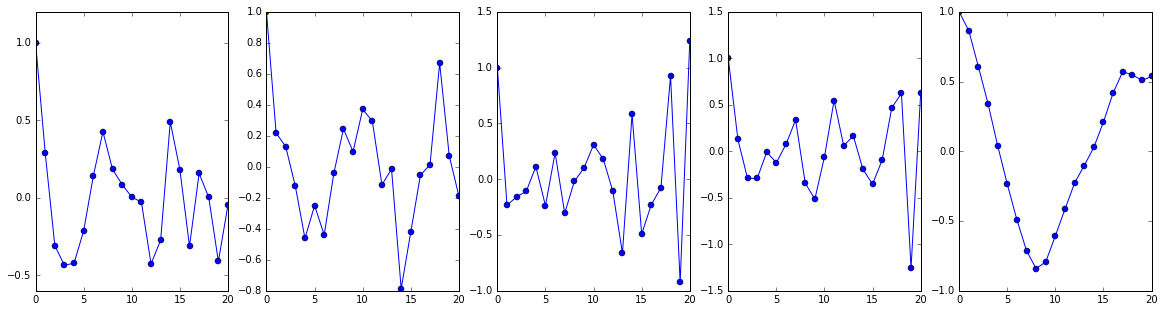

In [30]:

s, p = calc_stationarity(xcorr_list, corr_len=10, x_axis=df.Time)
true_perturbs = pd.read_csv(file_path.replace('timeseries.tsv', 'timeseries_perturbations.tsv'), sep="\t")
for idx in range(len(gene_list)):
    f = plt.figure(figsize=(20,5))
    for ii, ee in enumerate(xcorr_list):
        ax = f.add_subplot(1, 5, ii+1)
        ax.plot(ee[idx,idx], 'o-')

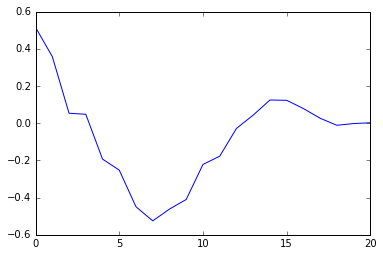

In [31]:
plt.plot(xcorr_list[1,2,3])

In [32]:
current_gold_standard = file_path.replace("timeseries.tsv","goldstandard.tsv")
evaluator = Evaluator(current_gold_standard, '\t')
true_edges = evaluator.gs_flat.tolist()

0.871000060369
0.574556782699
0.843919497468
0.889731398077
0.777843536541
0.691575155751
0.71437291883
0.725193407952
0.806144304633
0.753803484112
0.896293060692
0.796398321266
0.826684228506
0.686459603983
0.764858316298


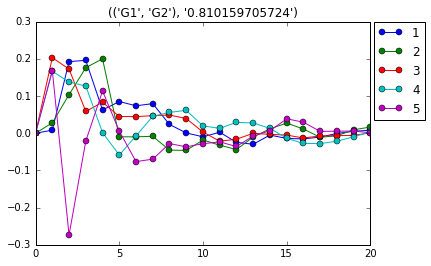

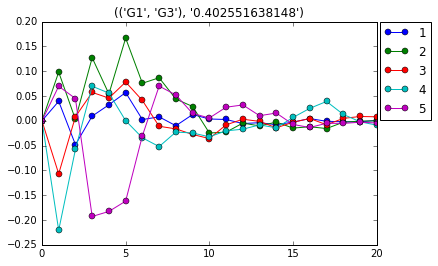

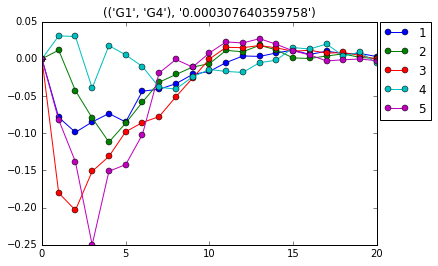

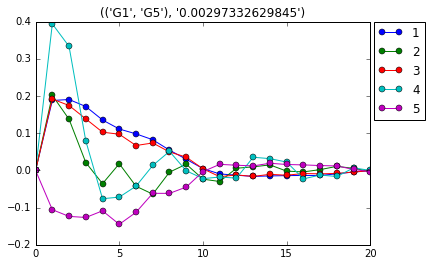

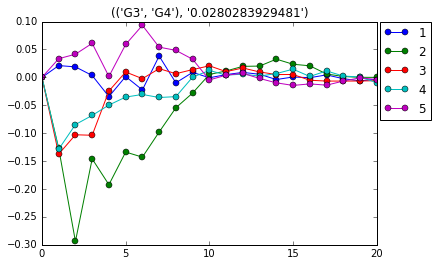

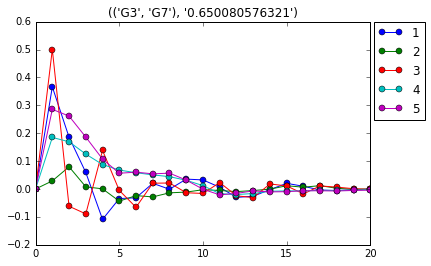

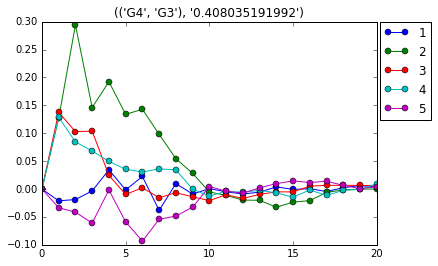

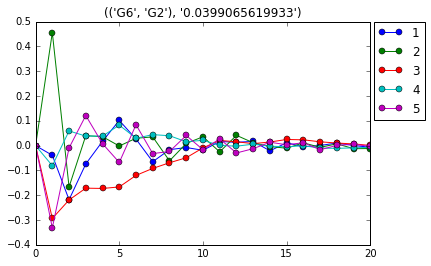

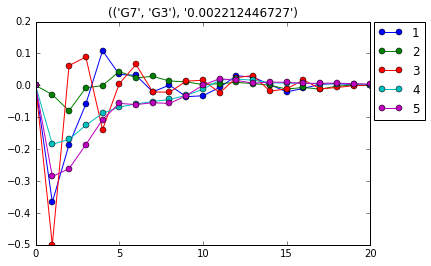

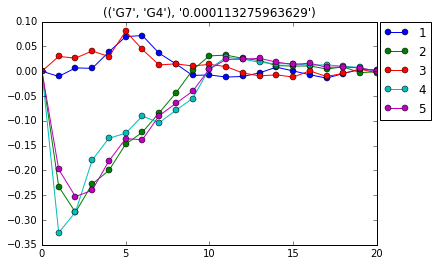

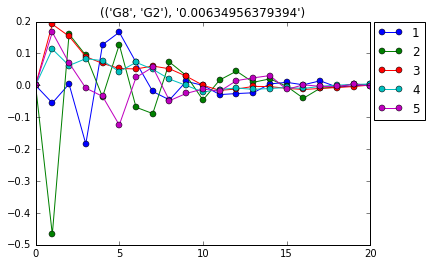

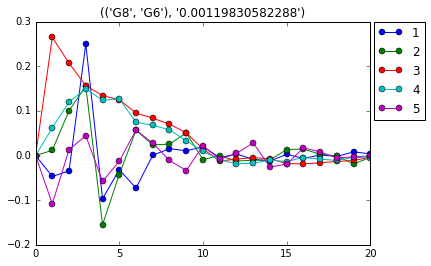

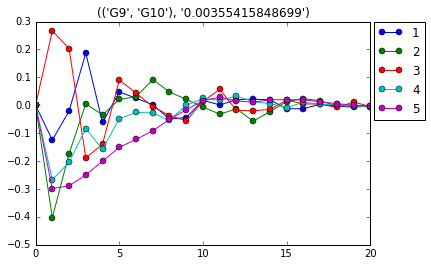

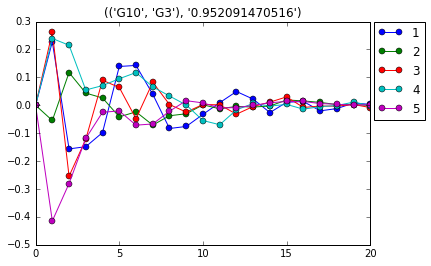

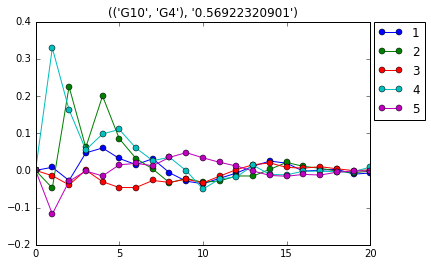

In [34]:

for edge in true_edges:
    p_idx = gene_list.index(edge[0])
    c_idx = gene_list.index(edge[1])
    forward = xcorr_list[:, p_idx, c_idx].T
    reverse = xcorr_list[:, c_idx, p_idx].T
    diff = (forward-reverse)
    diff = diff/np.max(np.abs(diff))/np.array(range(1,len(diff)+1))[:, None]
    max_abs = np.max(np.abs(reverse))
    print(max_abs)
    plt.figure()
#     plt.plot(forward, 'o-')
    plt.plot(diff, 'o-')
#     plt.plot((stats.norm.cdf(np.array(range(1,len(diff)+1)))-0.05/2)/np.sqrt(len(diff)))
    plt.legend([1,2,3,4,5], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title((edge, str(stats.linregress(range(len(reverse)), np.mean(reverse, axis=1)).pvalue)))

[ 0.23147897  0.36923407  0.21302417  0.17264088  0.39813393]


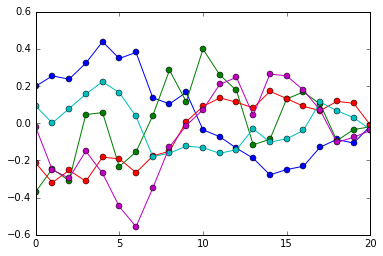

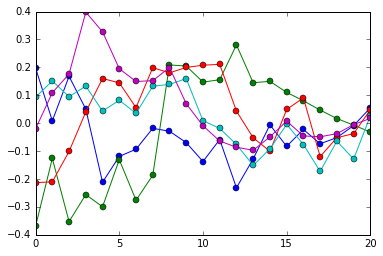

In [35]:
"""
A false edge that shouldn't show influence is G1 and G9
They are distant, and share no connections. Experiments 1-3 perturb G1 but not G9, while experiments 4-5 perturb G9,
but not G1
"""
p_idx = gene_list.index('G1')
c_idx = gene_list.index('G9')
forward = xcorr_list[:, p_idx, c_idx].T
reverse = xcorr_list[:, c_idx, p_idx].T
plt.plot(forward, 'o-')
plt.figure()
plt.plot(reverse, 'o-')
max_abs = np.max(np.abs(reverse), axis=0)
print(max_abs)

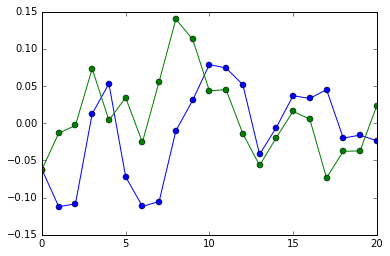

In [36]:

plt.plot(np.mean(forward, axis=1), 'o-')
plt.plot(np.mean(reverse, axis=1), 'o-')

In [37]:
stats.linregress(range(len(reverse)), np.mean(reverse, axis=1))

LinregressResult(slope=-0.0018677523088443326, intercept=0.028699460032758528, rvalue=-0.209224477610398, pvalue=0.36271220790550318, stderr=0.0020026730936494267)

In [38]:
edge_max_ccf= pd.DataFrame(np.max(np.max(np.abs(xcorr_list), axis=3), axis=0), index=gene_list, columns=gene_list)
a, b = np.meshgrid(range(len(gene_list)), range(len(gene_list)))
ll = pd.DataFrame()
gene_list = np.array(gene_list)
ll['Parent'] = gene_list[a.flatten()]
ll['Child'] = gene_list[b.flatten()]
ll['Max_ccf'] = edge_max_ccf.values.flatten()
ll['is_lag'] = ll['Max_ccf']>=0.5
ll['Edge'] = list(zip(ll['Parent'], ll['Child']))
ll['True_Edge'] = ll['Edge'].isin(true_edges)
ll[ll['is_lag']==False]

,Parent,Child,Max_ccf,is_lag,Edge,True_Edge
19,G10,G2,0.415101,False,"(G10, G2)",False
24,G5,G3,0.473365,False,"(G5, G3)",False
59,G10,G6,0.475403,False,"(G10, G6)",False
79,G10,G8,0.379432,False,"(G10, G8)",False
80,G1,G9,0.398134,False,"(G1, G9)",False
91,G2,G10,0.477972,False,"(G2, G10)",False
95,G6,G10,0.475403,False,"(G6, G10)",False


In [39]:
x = np.ma.masked_where(np.argmax(np.abs(xcorr_list), axis=3) == 0, np.argmax(np.abs(xcorr_list), axis=3))
for edge in true_edges:
    p_idx = list(gene_list).index(edge[0])
    c_idx = list(gene_list).index(edge[1])
    print(edge, np.mean(x[:, c_idx,p_idx])) # Get the reverse CCF which outlines the lag

('G1', 'G2') 3.0
('G1', 'G3') 6.66666666667
('G1', 'G4') 3.0
('G1', 'G5') 2.6
('G3', 'G4') 5.0
('G3', 'G7') 2.0
('G4', 'G3') 4.66666666667
('G6', 'G2') 5.5
('G7', 'G3') 1.6
('G7', 'G4') 1.5
('G8', 'G2') 5.0
('G8', 'G6') 4.0
('G9', 'G10') 4.75
('G10', 'G3') 4.2
('G10', 'G4') 3.0


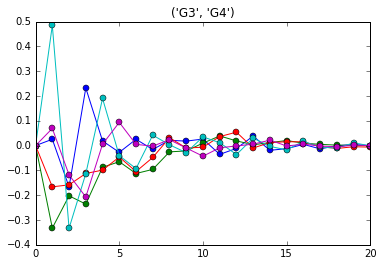

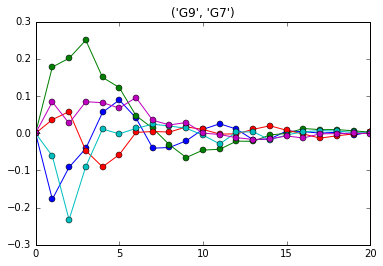

In [41]:
data_folder = "../data/dream4/"
nets = 5
insilico_dict = {ii:{} for ii in range(1, nets+1)}
for net in insilico_dict:
    data_file = data_folder + "insilico_size10_%i_timeseries.tsv"%(net)
    gold_file = data_folder + "insilico_size10_%i_goldstandard.tsv"%(net)
    perturb_file = data_folder + "insilico_size10_%i_timeseries_perturbations.tsv"%(net)
   
    # Calculate the xcorr for each gene pair
    df = pd.read_csv(data_file, sep="\t")
    gene_list = df.columns.values[1:].tolist()
    experiments=get_experiment_list(data_file)
    xcorr_list = xcorr_experiments(experiments)
    
    # Get the true edges
    evaluator = Evaluator(gold_file, '\t')
    true_edges = evaluator.gs_flat.tolist()
    dg = nx.DiGraph()
    dg.add_edges_from(true_edges)
#     print(nx.shortest_path(dg, 'G9', 'G7'))
    
    # Get the true perturbations
    true_perturbs = pd.read_csv(perturb_file, sep="\t")
    edge_max_ccf= pd.DataFrame(np.max(np.max(np.abs(xcorr_list[:, :, :, :10]), axis=3), axis=0), index=gene_list, columns=gene_list)
    a, b = np.meshgrid(range(len(gene_list)), range(len(gene_list)))
    ll = pd.DataFrame()
    gene_list = np.array(gene_list)
    ll['Parent'] = gene_list[a.flatten()]
    ll['Child'] = gene_list[b.flatten()]
    ll['Max_ccf'] = edge_max_ccf.values.flatten()
    ll['is_lag'] = ll['Max_ccf']>=0.5
    ll['Edge'] = list(zip(ll['Parent'], ll['Child']))
    ll['True_Edge'] = ll['Edge'].isin(true_edges)
#     print(ll[ll['is_lag']==False], '\n')
    false_neg = ll[(ll['is_lag']==False) & (ll['True_Edge']==True)]['Edge'].values
    genes = list(gene_list)
    x = np.ma.masked_where(np.argmax(np.abs(xcorr_list), axis=3) == 0, np.argmax(np.abs(xcorr_list), axis=3))
    for edge in true_edges:
        p_idx = list(gene_list).index(edge[0])
        c_idx = list(gene_list).index(edge[1])
#         print(edge, np.mean(x[:, c_idx,p_idx]))
    print()
    for falsey in false_neg:
        p_idx = genes.index(falsey[0])
        c_idx = genes.index(falsey[1])
        forward = xcorr_list[:, p_idx, c_idx].T
        reverse = xcorr_list[:, c_idx, p_idx].T
        diff = (forward-reverse)
        diff = diff/np.max(np.abs(diff))/np.array(range(1,len(diff)+1))[:, None]
        max_abs = np.max(np.abs(reverse))
        plt.figure()
        plt.plot(diff, 'o-')
        plt.title(falsey)

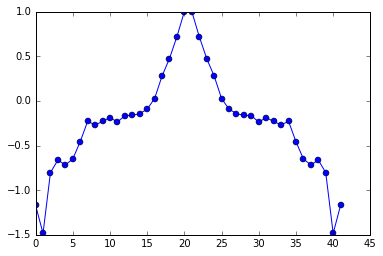

In [50]:
test = np.concatenate((xcorr_list[:, :, :, ::-1], xcorr_list), axis=3)
plt.plot(test[1,0,0], 'o-')